In [157]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
words = open('../names.txt').read().splitlines()

In [2]:
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [17]:
# build indices
itoch = {}
chtoi = {}
chars = sorted(list(set(''.join(words))))
chtoi = { ch: i+1 for i, ch in enumerate(chars) }
chtoi['.'] = 0
itoch = {i: ch for ch, i in chtoi.items()}
vocab_size = len(itoch)
print (chtoi, itoch)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [44]:
#build data set
def build_dataset(words, block_size):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size # initial set contains "..." padding for start of the word.
        for ch in list(word) + ['.']:
            idx = chtoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    return torch.tensor(X), torch.tensor(Y)
#X, Y = build_dataset(words[:3], 3)
#print(X, Y)
random.seed(42)
random.shuffle(words)
words_length = len(words)
n1 = int(0.8 * words_length)
n2 = int(0.9 * words_length)
block_size = 3
Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xtest, Ytest = build_dataset(words[n2:], block_size)
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xtest.shape, Ytest.shape)

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [127]:
# Build parameters - MLP
n_embeddings = 2
n_hidden = 100

# C, W1, b1, W2 , b2
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embeddings), generator=g) # we are creating embeddings from vocabilary size.
W1 = torch.randn((block_size * n_embeddings, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn(n_hidden, vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

total_parameters = sum([p.nelement() for p in parameters])
print(total_parameters)
for p in parameters:
  p.requires_grad = True

3481


In [163]:
# gradient descent.
epoch = 10000
batch_size = 32
X_input = Xtr
Y_input = Ytr
lossi = []
for i in range(epoch):
    #forward pass
    idx = torch.randint(0, X_input.shape[0], (batch_size,)) # get the batch indices - random.
    Xbatch, Ybatch = X_input[idx], Y_input[idx] # ge the input batch from input based on indices.
    emb = C[Xbatch] #embeddings
    hpreact = emb.view(emb.shape[0], -1) @ W1 + b1 #embeddings x W1 + b1
    h = torch.tanh(hpreact) # acitvation function.
    logits = h @ W2 + b2 # 2-layer values
    loss = F.cross_entropy(logits, Ybatch) # loss function.

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -0.001 * p.grad
    lossi.append(loss.log10().item())
print(loss.item())

2.596635580062866


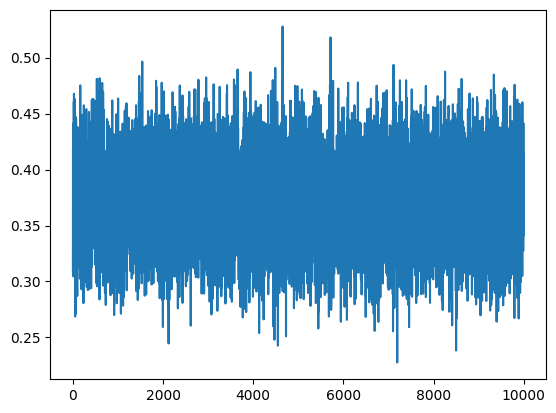

In [164]:
plt.plot(lossi)

In [98]:
# check loss values.
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(slice):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[slice]
    emb = C[x] #embeddings
    hpreact = emb.view(emb.shape[0], -1) @ W1 + b1 #embeddings x W1 + b1
    h = torch.tanh(hpreact) # acitvation function.
    logits = h @ W2 + b2 # 2-layer values
    loss = F.cross_entropy(logits, y) # loss function.
    print(f'{slice} loss is {loss}')

split_loss('train')
split_loss('test')
split_loss('dev')

train loss is 2.6030540466308594
test loss is 2.5967578887939453
dev loss is 2.6033716201782227


In [152]:
# generate sample values.
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor(context)] #embeddings
        hpreact = emb.view(1, -1) @ W1 + b1 #embeddings x W1 + b1
        h = torch.tanh(hpreact) # acitvation function.
        logits = h @ W2 + b2 # 2-layer values
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(itoch[idx])
        if idx == 0:
            break;
    print(''.join(out))

cexbmkmjmlkmrkicazktahkmmmjimjttainrlkaakzkatdakskmzcpbbjtbhrmgmtasmmczjmdckjkjkwptedagkkjemkmmsadsuenkavgjnyrftbspmhgcjdgbvtahlasckdsdrdbanjglhpyawaisanjjrpfdncjkazkmkdesjjfarmttgbcksjbhaabsaathrkmcslqevmcmabrmcaahrkjecaxmaldkmlmtjavjzscblmysoehlbptjapmdeagpschacfkeatksillmllbhmijsmdezhsamjhkamcxmmmkcasbcrfmbalcsahrcjmrckasvzasezazemnsckckcrnkajascyvtamisksddagnkclrbjwccgjzeaclajkacuutstomckzadbajrddbmkahmdcvhfacdvaaaajajkdjsghkcrdklhamrlrklmlcmgroapnaaaydaenkaacgosflcamemjdkclfdtirskjpjjdahzymalerzalmzjbtjutfbsobcnkcajkvsmjaacrekmoradmlveimtacaamnefsmhmemkwobssajajkkskrcparmrxskfkkmjscymndmkcdswamcrzcansjdndszakckedaegzzklhnadqnosivkdrnfjsmtthtatkmdsjrstjtaaledjkjasjkcbczsrcagajajcakcjammkavpllcilscbahjenlcajkemadkdaddjwdaamfmclmrmoljlpjldkjeaaerjpksmkzahrmmtoadmsmdcdnkaaomtzfkkedeadjhbmmjkajhltedjslkezaisndkoatiycrdfetiakvzlzfauamckndsmjldsbkcylrodgmkjgftrahdrnjapspdaknakahavseelvlascjadabgmanzadakamaykmkxhjjkokkakaabcsajdzcbclmzguhbcdetjmrtascppbadpbdsyrcckkcodaedjaaarrrviiaaynlldb